In [29]:
# PLEASE NOTE THAT THIS CODE INCLUDES HARD_CODED FILE PATHS FROM MY COMPUTER. 
# THIS CODE WILL NOT WORK ON YOUR MACHINE, AS I HAVE DOWNLOADED ALL IMAGES 

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np

import glob
import os

from PIL import Image
import scipy.io as io
import cv2

In [31]:
# making sure Im grabbing all the image files
len(glob.glob("../../../data/2023_imagery/filtered/*/*.png"))
img_ex = glob.glob("../../../data/2023_imagery/filtered/*/*.png")[0]

In [32]:
print(Image.open(img_ex).size[0])
Image.open(img_ex).size[1]

1488


281

# Making Dataframe

In [33]:
opus_id = []
x_length = []
y_length = []
folder = []
full_path = []

for filepath in glob.glob("../../../data/2023_imagery/filtered/*/*.png"):
    file_split = filepath.split("/")

    opus_id.append(file_split[-1].split('.')[0])
    x_length.append(Image.open(filepath).size[0])
    y_length.append(Image.open(filepath).size[1])
    folder.append(file_split[-2])
    full_path.append(filepath)

fileres_data = {"opus_id": opus_id, "x_length": x_length, "y_length": y_length, "folder": folder, "full_path": full_path}

In [34]:
res_df = pd.DataFrame(fileres_data)

In [35]:
res_df.set_index('opus_id', inplace=True)

In [36]:
res_df

,x_length,y_length,folder,full_path
opus_id,,,,
W1630641951,1488,281,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...
W1630637151,1488,285,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...
W1630646151,1488,283,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...
bad_bad_W1630655751,1442,1108,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...
W1630639551,1488,285,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...
...,...,...,...,...
W1597976395,1488,601,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...
W1598009545,1488,494,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...
W1598003695,1488,517,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...


# Visualiation X/Y resolution distributions

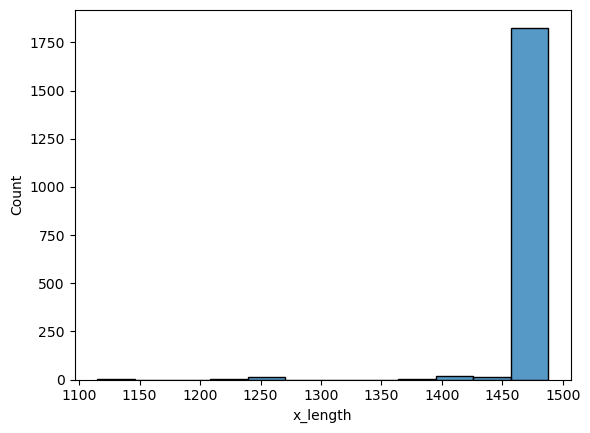

Of the 1883 pngs, 59 are not of x dimension 1488


In [37]:
sb.histplot(res_df['x_length'])
plt.show()
num_not_mode = len(res_df.loc[res_df['x_length'] != res_df['x_length'].mode()[0]])

print(f"Of the {len(res_df)} pngs, {num_not_mode} are not of x dimension 1488")

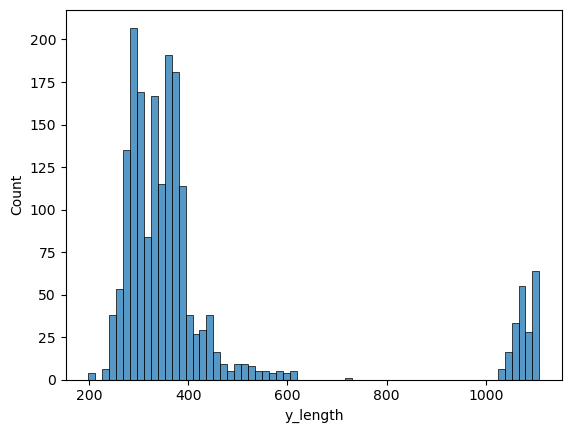

count    1883.000000
mean      421.791290
std       236.137146
min       199.000000
25%       299.000000
50%       347.000000
75%       386.000000
max      1108.000000
Name: y_length, dtype: float64

In [38]:
sb.histplot(res_df['y_length'])
plt.show()
res_df['y_length'].describe() # statisicall summary of this column

#### What am I looking for/Why is that far right cluster a problem?

Well, the expected output from my cropping method is that these images are long and skinny.

Im expecting x_length to be consistent, around 1500 pixels. 
The y axis is bound to vary much more(since the original images vary significantly along the y axis),

however, the y axis should stay well within the range of x_length/2. 

So, seeing a cluster of images that have y axis over 1000 is a sign that my cropping method messed up. 

# Lets explore the Y distribution, given this odd clustering

In [39]:
guessing_fine = res_df.loc[(res_df['y_length'] > 400) & (res_df['y_length'] < 800)]
guessing_fine = list(guessing_fine['full_path'])

#all but that one at 717 are good

In [40]:
f = open("resolution_400_800.txt", "w")
for x in guessing_fine: 
    f.write(x+"\n")
f.close()
# these are in fact fine
# I checked this externally via terminal window

In [41]:
guessing_bad = res_df.loc[res_df['y_length'] > 700]
guessing_bad = list(guessing_bad['full_path'])

In [42]:
len(guessing_bad)

203

In [43]:
f = open("resolution_800.txt", "w")
for x in guessing_bad: 
    f.write(x+"\n")
f.close()
# all of these are bad. 
# I checked this externally via terminal window



# What does this mean?

In [44]:
print(f'This means that {len(guessing_bad)} out of {len(res_df)} are bad, or {(len(guessing_bad)/len(res_df)) * 100} percent are poorly cropped')
print(f"this leaves {len(res_df) - len(guessing_bad)} good ones if I don't fix cropping algorithm")
print("Is this a problem?")

This means that 203 out of 1883 are bad, or 10.780669144981413 percent are poorly cropped
this leaves 1680 good ones if I don't fix cropping algorithm
Is this a problem?


# Identifying appropriate X/Y resolution to map all images to

Remember, Unet requires that all images fed to it are the same resolution. 

on top of this, the image needs to be divisible by 8 since the decode scales images down factor of 2^3

<AxesSubplot: xlabel='y_length', ylabel='Count'>

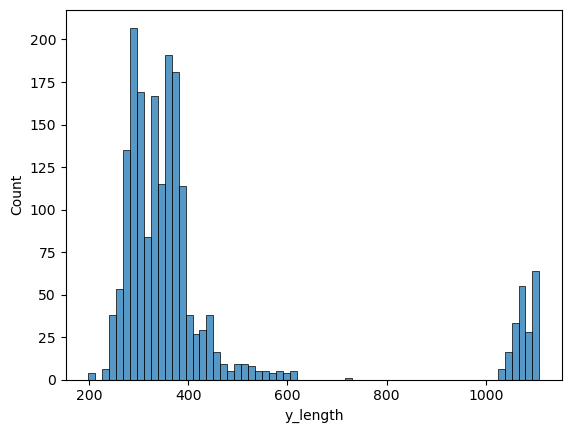

In [45]:
sb.histplot(res_df['y_length'])

In [46]:
clean_res_df = res_df.loc[res_df['y_length'] < 700]

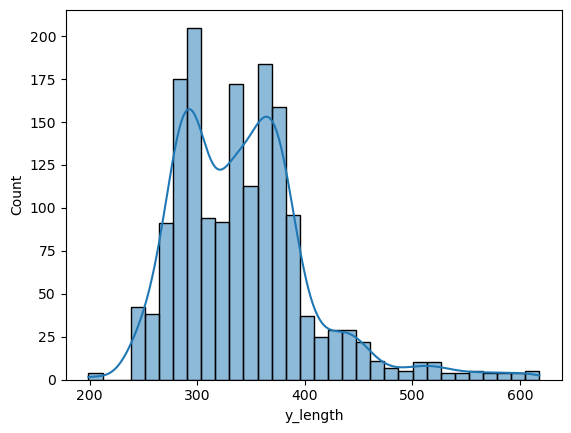

count    1680.000000
mean      342.392262
std        62.102235
min       199.000000
25%       295.000000
50%       337.000000
75%       374.000000
max       618.000000
Name: y_length, dtype: float64

In [47]:
sb.histplot(clean_res_df['y_length'], kde=True)
plt.show()
clean_res_df['y_length'].describe()

In [48]:
Y_list = np.arange(300,400)

for x in Y_list:
    if x%8 == 0:
        print(x)
# using 336

304
312
320
328
336
344
352
360
368
376
384
392


In [49]:
X_list = np.arange(1460,1500)

for x in X_list:
    if x%8 == 0:
        print(x)
# using 1488

1464
1472
1480
1488
1496


In [50]:
# attempting to calcualte the TOTAL pixel error of smushing across all images along the y axis
clean_res_df['pixel_error'] = clean_res_df['y_length'].apply(lambda x: abs(x-336))

/var/folders/21/1lgl4bt141nf87j2l6lc_nw00000gn/T/ipykernel_59328/4113122232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_res_df['pixel_error'] = clean_res_df['y_length'].apply(lambda x: abs(x-336))


In [51]:
clean_res_df

,x_length,y_length,folder,full_path,pixel_error
opus_id,,,,,
W1630641951,1488,281,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,55
W1630637151,1488,285,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,51
W1630646151,1488,283,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,53
W1630639551,1488,285,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,51
W1630648551,1488,281,117_SPKMVLFHP_005,../../../data/2023_imagery/filtered/117_SPKMVL...,55
...,...,...,...,...,...
W1597976395,1488,601,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...,265
W1598009545,1488,494,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...,158
W1598003695,1488,517,081_SPKMVLFLP,../../../data/2023_imagery/filtered/081_SPKMVL...,181


In [52]:
# percentage of pixels unaffected by image re-scaling that are cropped propperly
(clean_res_df.y_length.sum() - clean_res_df.pixel_error.sum()) / clean_res_df.y_length.sum()

0.8629617589126923

In [53]:
# percentage of pixels unaffected by image re-scaling(including impropperly cropped images)

res_df['pixel_error'] = res_df['y_length'].apply(lambda x: abs(x-336))
(res_df.y_length.sum() - res_df.pixel_error.sum()) / res_df.y_length.sum()

0.7108745166720597

In [54]:
res_df.to_csv("training_image_resolution.csv")

# Labeling the files that are all bad

In [55]:
dirt_res_df = res_df.loc[res_df['y_length'] > 700]

In [56]:
#putting bad infront of the improppelry cropped images

# for filepath in dirt_res_df['full_path']:
#     file_split = filepath.split("/")

#     new_filename = 'bad_'+file_split[-1]
#     file_split[-1] = new_filename

#     new_path = "/".join(map(str,file_split))

#     os.rename(filepath, new_path)